In [1]:
import pandas as pd

import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# from HH_tools import *
import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from IPython.display import display, HTML

In [51]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!

path = './data/disagg_struct_refs/sources/US/'
# agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['total_annual_wages', 'Wages'],
                                 ['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [52]:
# variable = 'annual_avg_emplvl'
variable = 'annual_avg_estabs'
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

#### Other Variables

# Population
county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)
county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# Wages
df_indu = df_cnt.groupby(level = 0).sum()
avg_wages_city = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_city = avg_wages_city.rename(columns= {'total_annual_wages': 'avg_annual_wages'})
# avg_wages_city = np.log10(avg_wages_city)
avg_wages_city.index = avg_wages_city.index.astype(str).str.zfill(5)

# Area
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

In [53]:
X_vars = pd.concat([county_pop.loc[X.index], avg_wages_city.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X_vars = pd.concat([X_vars, X], axis = 1, sort = True)


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [54]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

In [55]:
fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)
C_corr = np.log10(X_).corr()

def cosine_similarity(table):
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
    return result

C_cos = cosine_similarity(X.fillna(0))

# # Wages area and population appear as the demeaned corrs.
# fillzero = .1
# X_ = X_vars.T.fillna(X_vars.min(1)).T.replace(0, fillzero)
# C_vars = np.log10(X_).corr()
# C_ = C_vars.copy()
# C_.loc[C.index, C.columns] = C.values
# C = C_

## Correlations. Do they imply proportionality?

In [98]:
df = C_corr
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = C_corr.stack()[~keep]

In [142]:
# plt.hist(undirected_corr_vals, 100)
# plt.show()

pares = pd.DataFrame(undirected_corr_vals.loc[undirected_corr_vals > .85], columns = ['corr'])
# display(pares)
pares['a'] = np.nan
pares['b'] = np.nan

for i, row in pares.iterrows():
#     display(industry_titles.loc[industry_titles.industry_code.isin(list(i))])
#     print('cos: '+str(undirected_cos_vals[i]))
#     print('corr: '+str(undirected_corr_vals[i]))
    
#     fig, axs = plt.subplots(1, 2, figsize = (14, 5))

    colx = i[0]; coly = i[1]


    fit_data_df = np.log10(X_)[list(i)]
    fit_data = fit_data_df.loc[(fit_data_df[i[0]] != np.log10(fillzero)) & (fit_data_df[i[1]] != np.log10(fillzero))].values
    
    z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
    p = np.poly1d(z); # print(p)
    pares.loc[i, ['a', 'b']] = np.array(p)
  
    # Plot scatter
#     fig, ax = plt.subplots(1)
#     np.log10(X_).plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--', c = 'r')
#     plt.show()


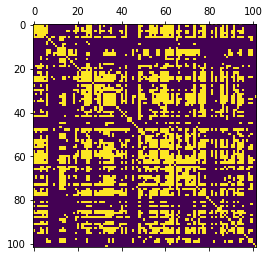

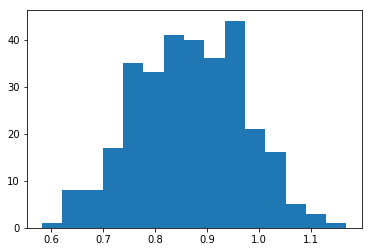

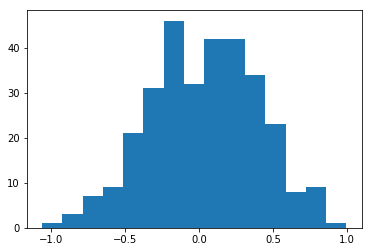

In [143]:
binary = C_corr > .8
plt.matshow(binary.loc[binary.sum(0) > 1, binary.sum(1) > 1])
plt.show()

# Coeficiente del ajuste lineal.
plt.hist(pares['a'], 15)
plt.show()
plt.hist(pares['b'], 15)
plt.show()

In [145]:
pares['a'].describe()

count    309.000000
mean       0.867416
std        0.105766
min        0.582151
25%        0.788264
50%        0.866571
75%        0.942467
max        1.167880
Name: a, dtype: float64

In [146]:
pares['b'].describe()

count    309.000000
mean       0.036852
std        0.366731
min       -1.060170
25%       -0.215276
50%        0.059077
75%        0.298989
max        0.996030
Name: b, dtype: float64

In [58]:
import scipy.linalg as la

In [59]:
# Because C is real, symmetric, we can express it as sum of eigenvals times matrix prod of eigenvecs.
def component(k, avals = avals, avecs = avecs):
    uk = np.array(len(avals)*[avecs.T[k]]).reshape(avecs.shape) # la componente k agarra el elemento k de todos los autovectores.
    return np.real(avals[k]*np.multiply(uk.T, uk))

In [82]:
# # Cosine va como corr.
# # i = 240
# # plt.plot(C_corr.iloc[:, i].values.flatten(), C_cos.iloc[:, i].values.flatten(), lw = 0, marker = '.', alpha = 1)
# plt.plot(C_corr.values.flatten(), C_cos.values.flatten(), lw = 0, marker = '.', alpha = .01)

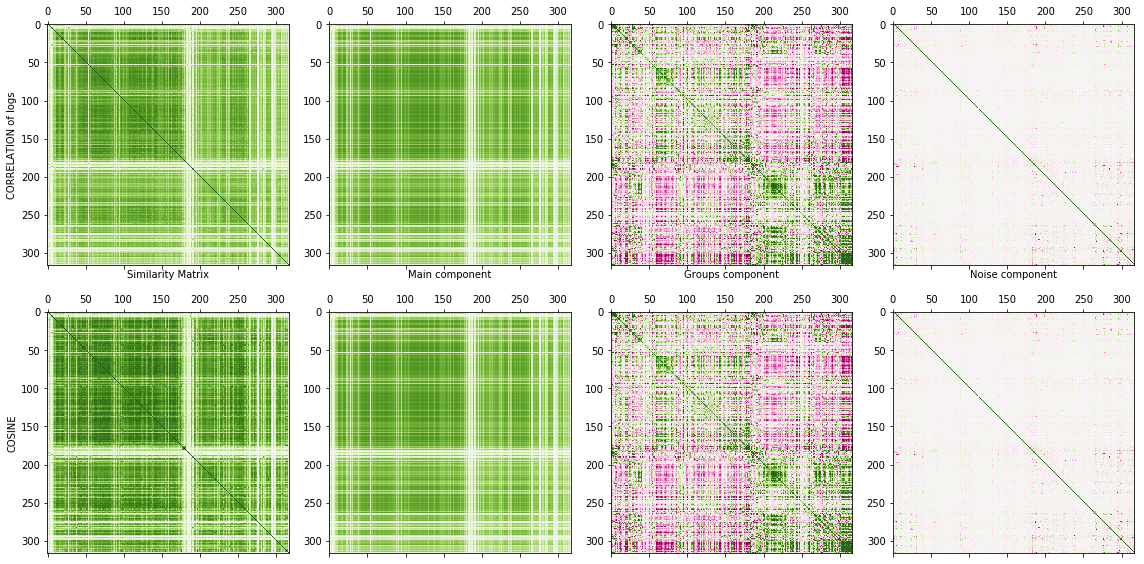

In [149]:
fig, axs = plt.subplots(2, 4, figsize = (16, 8))
cm = 'PiYG'
n_corte = 25 # ~20

avals, avecs = la.eig(C_corr.values)
avals = np.real(avals) # == np.abs(avals)

C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, n_corte)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(n_corte, len(avals))]).sum(axis=0) # random component

axs[0, 0].matshow(C_corr, vmin = -1, vmax = 1, cmap = cm); axs[0, 0].set_xlabel('Similarity Matrix')
axs[0, 0].set_ylabel('CORRELATION of logs')
axs[0, 1].matshow(C_s, vmin = -1, vmax = 1, cmap = cm); axs[0, 1].set_xlabel('Main component')
axs[0, 2].matshow(C_g, vmin = -.1, vmax = .1, cmap = cm); axs[0, 2].set_xlabel('Groups component')
axs[0, 3].matshow(C_r, vmin = -.1, vmax = .1, cmap = cm); axs[0, 3].set_xlabel('Noise component')

avals, avecs = la.eig(C_cos.values)
avals = np.real(avals) # == np.abs(avals)
C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, n_corte)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(n_corte, len(avals))]).sum(axis=0) # random component

axs[1, 0].matshow(C_cos, vmin = -1, vmax = 1, cmap = cm)
axs[1, 0].set_ylabel('COSINE')
axs[1, 1].matshow(C_s, vmin = -1, vmax = 1, cmap = cm)
axs[1, 2].matshow(C_g, vmin = -.1, vmax = .1, cmap = cm)
axs[1, 3].matshow(C_r, vmin = -.1, vmax = .1, cmap = cm)

plt.tight_layout()
plt.savefig('./Figures/eigenval_decomp.png')
plt.show()

In [18]:
# vals = np.log10(X_).values#[:3, :3]

# # # Apply Null
# # np.random.shuffle(vals) # counties are mixed up but industries info is kept
# # # np.sum(null, axis = 0)  # axis = 0 means industry sums. Check they are kept equal. 

# corr = pd.DataFrame(vals).corr()

# display(corr.iloc[:4, :4])

# avals, avecs = la.eig(corr.values)
# avals = np.real(avals) # == np.abs(avals)
# # plt.hist(avals, range(int(round(max(avals))) + 1))

# # avecs.T - avecs # != 0, i.e. not symmetric
# # np.round(avecs.T - np.linalg.inv(avecs), -13) # = 0. Its orthogonal

# avals[:10]

In [19]:
# plt.plot(avals) # the eigenvector has a value for each industry.
# plt.show()

(array([294.,  13.,   3.,   3.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

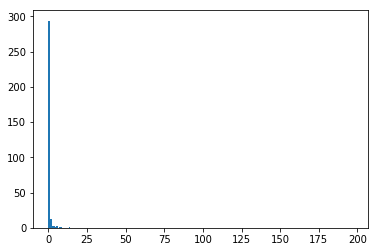

In [8]:
plt.hist(avals, range(int(round(max(avals))) + 1))
# Tiene un aval muy alto y los demas abajo. Esto esta OK. Va con la idea que hay una dependencia que todas las series tienen.

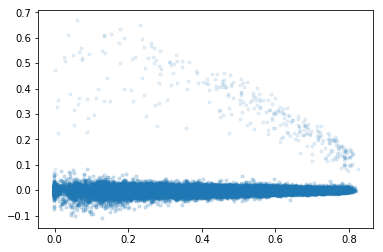

In [449]:
plt.plot(np.real(C_s).flatten(), np.real(C_r).flatten(), lw = 0, marker = '.', alpha = .1)

In [432]:
df = pd.DataFrame(np.real(component(6)), index = X.columns, columns=X.columns)
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = df.stack()[~keep]

pares = pd.DataFrame(undirected_corr_vals, columns = ['corr'])
pares = pares.reset_index().merge(industry_titles, left_on = 'level_0', right_on = 'industry_code').merge(industry_titles, left_on = 'level_1', right_on = 'industry_code')
pares = pares.sort_values('corr')

pares.head(10).drop(['industry_code_x', 'industry_code_y'], axis = 1)

,level_0,level_1,corr,industry_title_x,industry_title_y
319,1119,ALAND,-0.145390,NAICS 1119 Other crop farming,Area
2,1119,POPESTIMATE2010,-0.127384,NAICS 1119 Other crop farming,Population
607,1113,ALAND,-0.120324,NAICS 1113 Fruit and tree nut farming,Area
505,1131,ALAND,-0.118362,NAICS 1131 Timber tract operations,Area
325,1153,ALAND,-0.109061,NAICS 1153 Support activities for forestry,Area
323,1133,ALAND,-0.106642,NAICS 1133 Logging,Area
290,1113,POPESTIMATE2010,-0.105422,NAICS 1113 Fruit and tree nut farming,Population
322,1132,ALAND,-0.103711,NAICS 1132 Forest nursery and gathering forest...,Area
188,1131,POPESTIMATE2010,-0.103703,NAICS 1131 Timber tract operations,Population
1112,7224,1119,-0.103386,"NAICS 7224 Drinking places, alcoholic beverages",NAICS 1119 Other crop farming


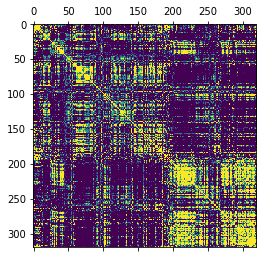

In [389]:
plt.matshow(np.real(C_r), vmin = 0, vmax = .05)
